In [97]:
%matplotlib inline
import matplotlib.pylab as pylab

#pylab.rcParams['figure.figsize'] = 13, 7

import pymc as mc

import pandas as pd
import numpy as np
import datetime

## Generate Test Data

In [98]:
def GaussFunction(wavelength_array, amplitude, centroid, sigma, *args, **kwargs):
    return amplitude * np.exp(-0.5 * ((wavelength_array - centroid) / sigma)**2)

Instrument detection region. Wavelength units are in Angstroms ($\unicode{x212B}$).

In [ ]:
wavelength_array = np.arange(5010, 5030, 0.01) 

Create some physical clouds. Each cloud is fully specified by 3 numbers: amplitude, centroid, and sigma-width

In [ ]:
clouds = pd.DataFrame({'cloud': pd.Series([], dtype='str'),
                       'amplitude': pd.Series([], dtype='float'),
                       'centroid': pd.Series([], dtype='float'),
                       'sigma': pd.Series([], dtype='float'),
                       'tau': pd.Series([], dtype='object')})

clouds = clouds.append({'cloud': '0', 'amplitude': 0.85, 'centroid': 5017.5, 'sigma': 1.2, 'tau':[]}, ignore_index=True)
clouds = clouds.append({'cloud': '1', 'amplitude': 0.35, 'centroid': 5018.1, 'sigma': 0.7, 'tau':[]}, ignore_index=True)
clouds = clouds.append({'cloud': '2', 'amplitude': 0.55, 'centroid': 5016.5, 'sigma': 0.9, 'tau':[]}, ignore_index=True)

Calculate tau for each cloud

In [ ]:
clouds.dtypes

clouds.set_value(0, 'tau', GaussFunction(wavelength_array, clouds.ix[0]['amplitude'], 
                                         clouds.ix[0]['centroid'], clouds.ix[0]['sigma']))

clouds.set_value(1, 'tau', GaussFunction(wavelength_array, clouds.ix[1]['amplitude'],
                                         clouds.ix[1]['centroid'], clouds.ix[1]['sigma']))

clouds.set_value(2, 'tau', GaussFunction(wavelength_array, clouds.ix[2]['amplitude'],
                                         clouds.ix[2]['centroid'], clouds.ix[2]['sigma']))

In [ ]:
pylab.plot(wavelength_array, clouds.ix[0]['tau'], label='comp_1')
pylab.plot(wavelength_array, clouds.ix[1]['tau'], label='comp_2')
pylab.plot(wavelength_array, clouds.ix[2]['tau'], label='comp_2')
pylab.plot(wavelength_array, sum(clouds['tau']), color='black', label='combined', linewidth=2.0)

pylab.ylabel("Optical Depth")
pylab.xlabel("Wavelength (Angstroms)")
pylab.legend()
pylab.title("Toy example")

Add noise and convert to Voigt absorbtion

In [103]:
def VoigtAbsorption(tau_array):
    return np.exp(-tau_array)

In [104]:
onesigmaerror = 0.02 
noise = np.random.normal(0.0, onesigmaerror, len(wavelength_array))

flux_array = VoigtAbsorption(sum(clouds['tau'])) + noise

(0, 1.1)

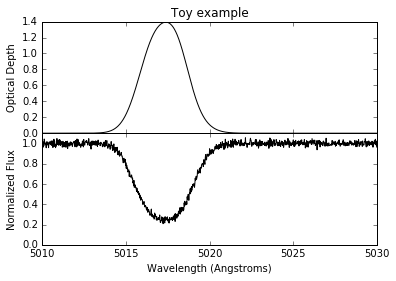

In [105]:
f, (ax1, ax2) = pylab.subplots(2, sharex=True, sharey=False)
ax1.plot(wavelength_array, sum(clouds['tau']), color='black', label='combined')
ax2.plot(wavelength_array, flux_array, color='black', label='flux')
f.subplots_adjust(hspace=0)

ax1.set_title("Toy example")
ax1.set_ylabel("Optical Depth")

ax2.set_ylabel("Normalized Flux")
ax2.set_xlabel("Wavelength (Angstroms)")
ax2.set_ylim(0, 1.1)

## PyMC 

In [181]:
height_lower = 0
height_higher = 1
wavelength_lower = wavelength_array[0]
wavelength_upper = wavelength_array[-1]
sigma_lower = 0
sigma_upper = 5

In [182]:
fitComponents = 4

In [183]:
estimated_variables = {}
for component in range(1, fitComponents + 1):
    estimated_variables[component] = {}
    estimated_variables[component]['height'] = mc.Uniform("est_height_" + str(component), height_lower, height_higher)
    estimated_variables[component]['centroid'] = mc.Uniform("est_centroid_" + str(component), wavelength_lower, wavelength_upper)
    estimated_variables[component]['sigma'] = mc.Uniform("est_sigma_" + str(component), sigma_lower, sigma_upper)

In [184]:
print estimated_variables[1]['centroid'].random()
print estimated_variables[1]['centroid'].value

5024.95708876
5024.95708876


Create deterministic variables for each fitted gaussian

In [185]:
estimate_profiles = []
for component in range(1, fitComponents + 1):
    
    @mc.deterministic( trace = True)    
    def profile(x=wavelength_array, centroid=estimated_variables[component]['centroid'], \
             sigma=estimated_variables[component]['sigma'], height=estimated_variables[component]['height']):
        return GaussFunction( x, height, centroid, sigma )
    
    estimate_profiles.append(profile)

Create a deterministic variable for the total absorption from **all** components.

In [186]:
@mc.deterministic( trace=False )
def mean(profile_sum=estimate_profiles):
    
    temp = profile_sum[0].copy()
    
    for component in range(1, fitComponents):
        temp += profile_sum[component]
    
    return VoigtAbsorption(temp)

Create a variable for the sampling distribution.

In [187]:
std_deviation = 1./mc.Uniform("std", 0, 1)**2

mc.Normal("obs", mean, std_deviation, value=flux_array, observed = True)

<pymc.distributions.Normal 'obs' at 0x7f255b10a390>

In [188]:
trymodel = mc.Model([estimated_variables[x][y] for x in estimated_variables for y in estimated_variables[x]] + [std_deviation])

Calculate the Maximum A Posteriori (MAP) estimate. Useful to do in advance so as to start the sampling with good initial values

In [189]:
tryMAP = mc.MAP(trymodel)
tryMAP.fit()

print tryMAP.BIC
print tryMAP.AIC

-2941.79135124
-3005.59216986


Sample an MCMC

In [190]:
trymcmc = mc.MCMC(trymodel)

starttime=datetime.datetime.now()
trymcmc.sample(iter=10000, burn=6000, thin=2.0)
fit_time = str(datetime.datetime.now() - starttime)
print "\nTook:", fit_time, " to finish."

 [-----------------100%-----------------] 10000 of 10000 complete in 12.8 sec
Took: 0:00:12.770467  to finish.


In [191]:
print trymcmc.BPIC

-4997.63427919


In [192]:
trymcmc.logp

2464.935719909816

In [194]:
mc.flib.logsum(-trymcmc.logp)

-2464.935719909816

Construct each component given our estimated parameters. Sum to give the estimated total absorption.

In [195]:
fit = {}
fit['total'] = np.zeros_like(wavelength_array)

for fitcomponent in range(1, fitComponents+1):
    fit[fitcomponent] = GaussFunction(wavelength_array, 
                                      estimated_variables[fitcomponent]['height'].value,
                                      estimated_variables[fitcomponent]['centroid'].value,
                                      estimated_variables[fitcomponent]['sigma'].value)
    
    fit['total'] += fit[fitcomponent]

Plot the fit with residuals.

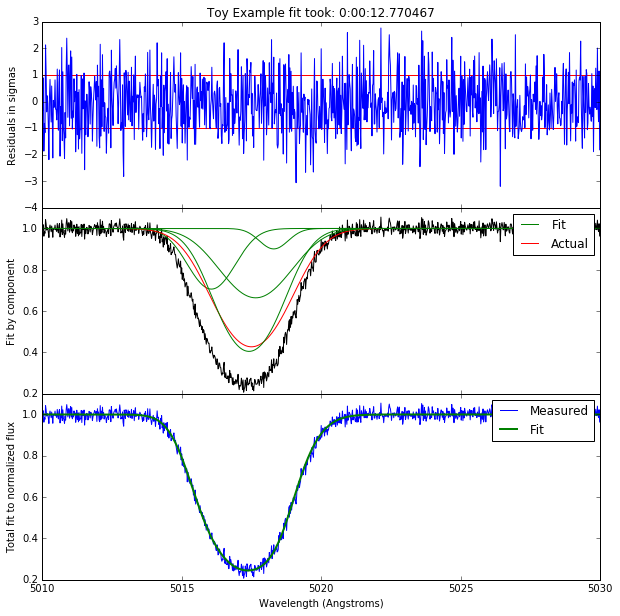

In [199]:
f, (ax1, ax2, ax3) = pylab.subplots(3, sharex=True, sharey=False, figsize=(10,10))

ax1.plot(wavelength_array, (flux_array - VoigtAbsorption(fit['total'])) / onesigmaerror)
ax1.hlines(1, wavelength_array[0], wavelength_array[-1], color='red', linestyles='-')
ax1.hlines(-1, wavelength_array[0], wavelength_array[-1], color='red', linestyles='-')

ax2.plot(wavelength_array, flux_array, color='black', linewidth=1.0)

for fitcomponent in range(1, fitComponents+1):
    if fitcomponent == 1:
        ax2.plot(wavelength_array, VoigtAbsorption(fit[fitcomponent]), color="green", label="Fit")
        ax2.plot(wavelength_array, VoigtAbsorption(clouds.ix[fitcomponent-1]['tau']), color="red", label="Actual")
    else: 
        ax2.plot(wavelength_array, VoigtAbsorption(fit[fitcomponent]), color="green")
        ax2.plot(wavelength_array, VoigtAbsorption(clouds.ix[fitcomponent-1]['tau']), color="red")

ax2.legend()

ax3.plot(wavelength_array, flux_array, label="Measured")
ax3.plot(wavelength_array, VoigtAbsorption(fit['total']), color='green', label="Fit", linewidth=2.0)
ax3.legend()

f.subplots_adjust(hspace=0)

ax1.set_title("Toy Example fit took: " + fit_time)
ax1.set_ylabel("Residuals in sigmas")
ax2.set_ylabel("Fit by component")
ax3.set_ylabel("Total fit to normalized flux")
ax3.set_xlabel("Wavelength (Angstroms)")

# VPfit function

In [200]:
class VPfit():
    
    def __init__(self):
        self.estimated_variables = []
        self.estimate_profiles = []
        self.bic = True
        self.init = True
        self.trymodel =None
        self.trymcmc = None
        self.tryMAP = None
        #self.fitComponents = 1
        
        
    def fit(self, wavelength_array, fitComponents = 1, sigma_upper = 5):
        
        #for var in self.estimated_variables:
        #    var.random()

        print "Fit components: ", fitComponents, ". BIC=", self.bic

        height = mc.Uniform("height_" + str(fitComponents), 0, 1)
        centroid = mc.Uniform("centroid_" + str(fitComponents), wavelength_array[0], wavelength_array[-1])
        sigma = mc.Uniform("sigma_" + str(fitComponents), 0, sigma_upper)

        self.estimated_variables.extend({height, centroid, sigma})
        print "self.estimated_variables: ", self.estimated_variables

        @mc.deterministic( trace = True)    
        def profile(x=wavelength_array, centroid=centroid, sigma=sigma, height=height):
            return GaussFunction( x, height, centroid, sigma )

        self.estimate_profiles.append(profile)
        print "self.estimate_profiles: ", self.estimate_profiles
        
        print "self.fitComponents: ", fitComponents

        @mc.deterministic( trace=False )
        def mean(profile_sum=self.estimate_profiles):

            temp = profile_sum[0].copy()
            
            for component in range(1, fitComponents):
                temp += profile_sum[component]

            return VoigtAbsorption(temp)

        std_deviation = 1./mc.Uniform("std", 0, 1)**2
        
        print "std_deviation: ", std_deviation

        mc.Normal("obs", mean, std_deviation, value=flux_array, observed = True)

        self.trymodel = mc.Model(self.estimated_variables)# + [std_deviation])

        print "trymodel.variables: ", trymodel.variables

        self.tryMAP = mc.MAP(self.trymodel)
        self.tryMAP.fit()


        print "\nBIC: ", self.tryMAP.BIC
        print "\nAIC: ", self.tryMAP.AIC

        if((self.init==True) or (self.bic > self.tryMAP.BIC)):
            self.init = False
            self.bic = self.tryMAP.BIC
            #self.fitComponents += 1
            
            print "recurse"
            
            self.fit(wavelength_array, fitComponents = fitComponents + 1)
        else:
            print "\nComplete!"
            
            self.trymcmc = mc.MCMC(self.trymodel)
            
            starttime=datetime.datetime.now()
            self.trymcmc.sample(iter=10000, burn=6000, thin=2.0)
            fit_time = str(datetime.datetime.now() - starttime)
            print "\nFit Components: ", fitComponents, "\nTook:", fit_time, " to finish."
            
            return self.estimated_variables

In [ ]:
vpfit = VPfit()
vpfit.fit(wavelength_array)

Fit components:  1 . BIC= True
self.estimated_variables:  [<pymc.distributions.Uniform 'sigma_1' at 0x7f255b9dea90>, <pymc.distributions.Uniform 'centroid_1' at 0x7f255b9de950>, <pymc.distributions.Uniform 'height_1' at 0x7f255b9dee50>]
self.estimate_profiles:  [<pymc.PyMCObjects.Deterministic 'profile' at 0x7f255b9def10>]
self.fitComponents:  1
std_deviation:  ((std_pow_2)_rdiv_1.0)
trymodel.variables:  set([<pymc.distributions.Uniform 'est_sigma_3' at 0x7f255aa43c10>, <pymc.distributions.Uniform 'est_sigma_4' at 0x7f25623df250>, <pymc.PyMCObjects.Deterministic '((std_pow_2)_rdiv_1.0)' at 0x7f255b10a590>, <pymc.distributions.Uniform 'est_height_1' at 0x7f25623df110>, <pymc.distributions.Uniform 'est_centroid_1' at 0x7f25623df090>, <pymc.distributions.Uniform 'est_centroid_4' at 0x7f25623df190>, <pymc.distributions.Uniform 'est_height_3' at 0x7f25623df1d0>, <pymc.distributions.Uniform 'est_centroid_2' at 0x7f25623df310>, <pymc.distributions.Uniform 'est_height_4' at 0x7f255aa43f90>, <p

In [179]:
vpfit.estimated_variables

[<pymc.distributions.Uniform 'centroid_1' at 0x7f255aa43690>,
 <pymc.distributions.Uniform 'sigma_1' at 0x7f255aa435d0>,
 <pymc.distributions.Uniform 'height_1' at 0x7f255aa43a50>,
 <pymc.distributions.Uniform 'sigma_2' at 0x7f255b10af10>,
 <pymc.distributions.Uniform 'centroid_2' at 0x7f255b10a750>,
 <pymc.distributions.Uniform 'height_2' at 0x7f255aa43250>,
 <pymc.distributions.Uniform 'sigma_3' at 0x7f255b10ac10>,
 <pymc.distributions.Uniform 'centroid_3' at 0x7f255b10add0>,
 <pymc.distributions.Uniform 'height_3' at 0x7f255b10ac90>,
 <pymc.distributions.Uniform 'sigma_4' at 0x7f255b10a490>,
 <pymc.distributions.Uniform 'height_4' at 0x7f255aa43350>,
 <pymc.distributions.Uniform 'centroid_4' at 0x7f255b10a510>,
 <pymc.distributions.Uniform 'centroid_5' at 0x7f255b10ab90>,
 <pymc.distributions.Uniform 'sigma_5' at 0x7f255b10acd0>,
 <pymc.distributions.Uniform 'height_5' at 0x7f255b10a850>,
 <pymc.distributions.Uniform 'sigma_6' at 0x7f255b107110>,
 <pymc.distributions.Uniform 'centro

In [ ]:
fit = {}
fit['total'] = np.zeros_like(wavelength_array)

for fitcomponent in range(1, fitComponents+1):
    fit[fitcomponent] = GaussFunction(wavelength_array, 
                                      vpfit.estimated_variables[fitcomponent]['height'].value,
                                      estimated_variables[fitcomponent]['centroid'].value,
                                      estimated_variables[fitcomponent]['sigma'].value)
    
    fit['total'] += fit[fitcomponent]

In [ ]:
f, (ax1, ax2, ax3) = pylab.subplots(3, sharex=True, sharey=False, figsize=(10,10))

ax1.plot(wavelength_array, (flux_array - VoigtAbsorption(fit['total'])) / onesigmaerror)
ax1.hlines(1, wavelength_array[0], wavelength_array[-1], color='red', linestyles='-')
ax1.hlines(-1, wavelength_array[0], wavelength_array[-1], color='red', linestyles='-')

ax2.plot(wavelength_array, flux_array, color='black', linewidth=1.0)

for fitcomponent in range(1, fitComponents+1):
    if fitcomponent == 1:
        ax2.plot(wavelength_array, VoigtAbsorption(fit[fitcomponent]), color="green", label="Fit")
        ax2.plot(wavelength_array, VoigtAbsorption(clouds.ix[fitcomponent-1]['tau']), color="red", label="Actual")
    else: 
        ax2.plot(wavelength_array, VoigtAbsorption(fit[fitcomponent]), color="green")
        ax2.plot(wavelength_array, VoigtAbsorption(clouds.ix[fitcomponent-1]['tau']), color="red")

ax2.legend()

ax3.plot(wavelength_array, flux_array, label="Measured")
ax3.plot(wavelength_array, VoigtAbsorption(fit['total']), color='green', label="Fit", linewidth=2.0)
ax3.legend()

f.subplots_adjust(hspace=0)

ax1.set_title("Toy Example fit took: " + fit_time)
ax1.set_ylabel("Residuals in sigmas")
ax2.set_ylabel("Fit by component")
ax3.set_ylabel("Total fit to normalized flux")
ax3.set_xlabel("Wavelength (Angstroms)")

Plotting est_centroid_1
Plotting est_centroid_2
Plotting est_sigma_2
Plotting est_height_1
Plotting std
Plotting est_sigma_1
Plotting est_height_2


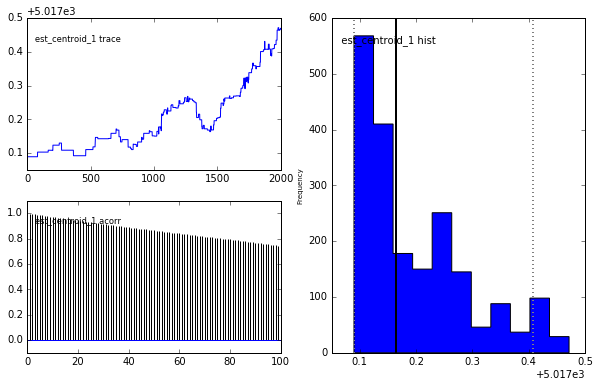

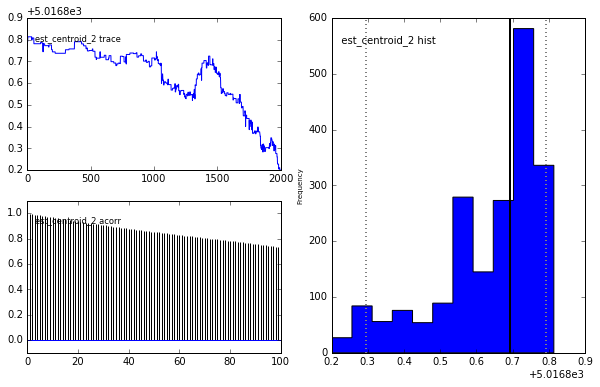

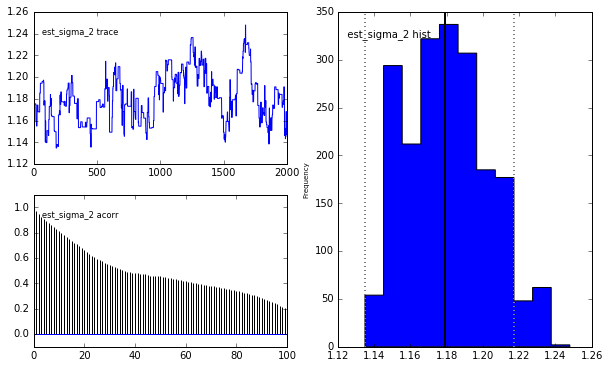

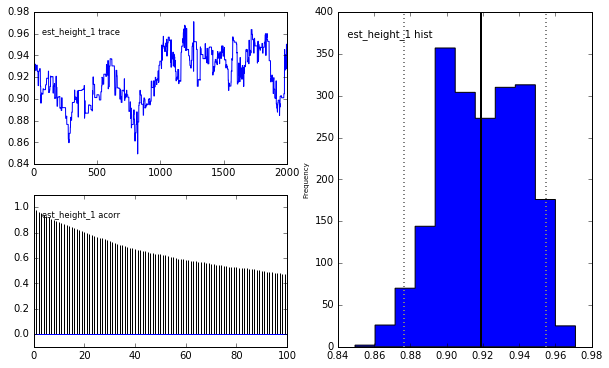

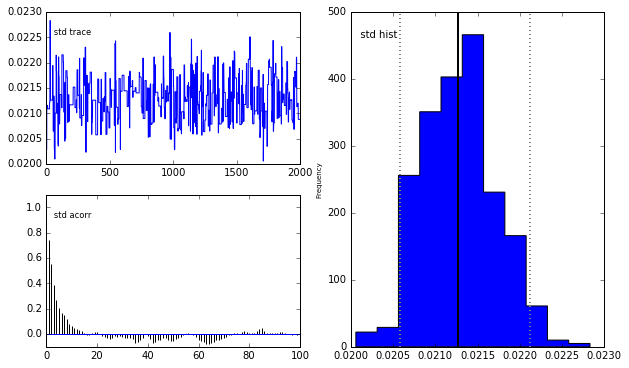

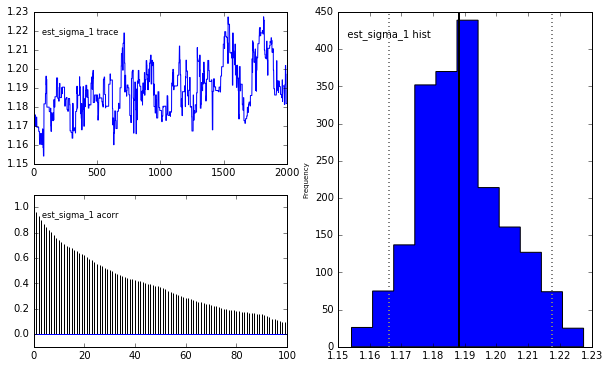

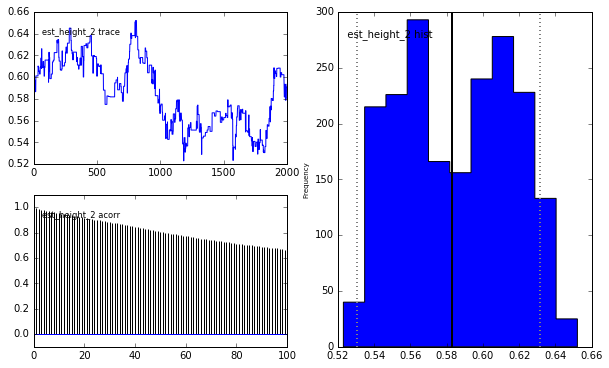

In [164]:
mc.Matplot.plot(vpfit.trymcmc)